In [24]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.math import confusion_matrix
from tensorflow.keras.losses import BinaryCrossentropy

from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, TextVectorization, Input, Dense, LSTM, Bidirectional, Dropout
from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [2]:
tf.test.is_built_with_cuda()

True

In [3]:
print(tf.config.list_physical_devices("GPU"))

[]


## Laden der Daten (ohne Metainformationen)

In [4]:
data = pd.read_csv("emails.csv")

In [5]:
X = data["text"]
y = data["spam"]

<AxesSubplot:ylabel='spam'>

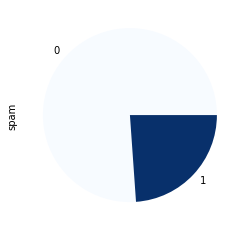

In [56]:
y.value_counts().plot(kind="pie", colormap="Blues")

In [7]:
data.sample(5)

,text,spam
2673,Subject: re : lunch fyi - - - - - - - - - - ...,0
2026,"Subject: re : presentation david , i am leav...",0
5335,"Subject: re : lsu seminar visit vince , plea...",0
3400,Subject: interview schedule for stephen bennet...,0
4641,"Subject: book order julie , we received the ...",0


In [8]:
X = X.str.replace("Subject: ", "")

In [9]:
X.head(5)

0    naturally irresistible your corporate identity...
1    the stock trading gunslinger  fanny is merrill...
2    unbelievable new homes made easy  im wanting t...
3    4 color printing special  request additional i...
4    do not have money , get software cds from here...
Name: text, dtype: object

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=999)

In [11]:
X_train.sample(5)

828     re : [ 3 ]  this will be our closing effort  w...
4343    re : credit . com cv ' s  my feedback :  phili...
2328    the ferc staff report on western markets and t...
4649    message 2  i am sorry to send you the multi - ...
1895    re : jeff skilling ' s presentation  i want to...
Name: text, dtype: object

In [12]:
X_test.sample(5)

1416    azuix deal valuation  bob ,  please find the p...
1598    seminar mugs  vince :  our pr staff has put to...
4890    kirstee ' s role in london  vince :  this is p...
4543    re : invitation to speak at power 2000  hi vin...
4461    re : carl tricoli  carl ,  depends if it is mo...
Name: text, dtype: object

## Erstellung des RNN

In [13]:
max_tokens = 10000
sequence_len = 256

vectorization_layer = TextVectorization(max_tokens=max_tokens, output_sequence_length=sequence_len)
vectorization_layer.adapt(X_train)

In [14]:
print("   3 ---> ", vectorization_layer.get_vocabulary()[3])
print(" 313 ---> ", vectorization_layer.get_vocabulary()[313])
print("2699 ---> ", vectorization_layer.get_vocabulary()[2699])

   3 --->  to
 313 --->  23
2699 --->  corresponding


In [15]:
example_txt = "Example text to see the corresponding word vector"
txt_vector = vectorization_layer(example_txt)

print(example_txt)
print(txt_vector)

Example text to see the corresponding word vector
tf.Tensor(
[ 838 1365    3  126    2 2699 1209    1    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0 

In [16]:
model = Sequential([
    Input(dtype=tf.string, shape=1),
    vectorization_layer,
    Embedding(input_dim=vectorization_layer.vocabulary_size(), output_dim=256, mask_zero=True),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.03),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.002),
    LSTM(32),
    Dense(64, activation="relu"),
    Dense(1, activation="sigmoid"),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 256)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 256, 256)          2560000   
                                                                 
 bidirectional (Bidirectiona  (None, 256, 256)         394240    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256, 256)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 256, 128)         164352    
 nal)                                                            
                                                        

In [17]:
model.compile(optimizer="adam", loss=BinaryCrossentropy(), metrics=["accuracy"])

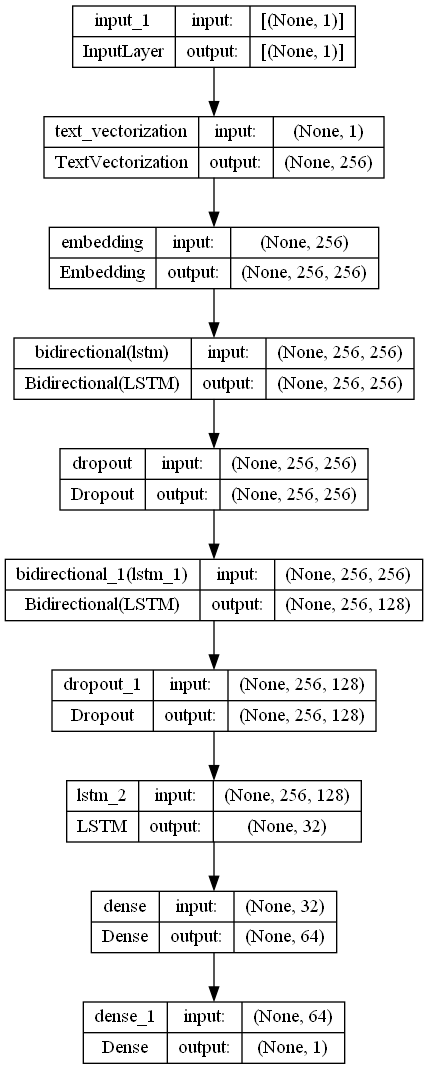

In [18]:
plot_model(model, to_file="model_rnn_plot.png", show_shapes=True, show_layer_names=True)

In [19]:
history = model.fit(X_train, y_train, epochs=10, validation_split=0.15)

Epoch 1/10
107/107 [==============================] - 99s 790ms/step - loss: 0.2458 - accuracy: 0.9031 - val_loss: 0.1056 - val_accuracy: 0.9718
Epoch 2/10
107/107 [==============================] - 77s 724ms/step - loss: 0.0473 - accuracy: 0.9853 - val_loss: 0.0743 - val_accuracy: 0.9718
Epoch 3/10
107/107 [==============================] - 77s 724ms/step - loss: 0.0173 - accuracy: 0.9971 - val_loss: 0.0892 - val_accuracy: 0.9784
Epoch 4/10
107/107 [==============================] - 78s 725ms/step - loss: 0.0468 - accuracy: 0.9918 - val_loss: 0.1003 - val_accuracy: 0.9751
Epoch 5/10
107/107 [==============================] - 78s 725ms/step - loss: 0.0362 - accuracy: 0.9921 - val_loss: 0.1363 - val_accuracy: 0.9568
Epoch 6/10
107/107 [==============================] - 83s 775ms/step - loss: 0.0386 - accuracy: 0.9886 - val_loss: 0.0859 - val_accuracy: 0.9651
Epoch 7/10
107/107 [==============================] - 81s 760ms/step - loss: 0.0063 - accuracy: 0.9985 - val_loss: 0.0382 - val_ac

In [20]:
model.save("rnn_model.tf")

INFO:tensorflow:Assets written to: rnn_model.tf\assets


INFO:tensorflow:Assets written to: rnn_model.tf\assets


## Evaluierung

In [21]:
accuracy = model.evaluate(X_test, y_test, verbose=0)
print("test loss, test accuracy:", accuracy)

test loss, test accuracy: [0.09828881174325943, 0.9784758687019348]


In [23]:
y_pred = model.predict(X_test)
y_pred_bin = np.round(y_pred)

confusion = confusion_matrix(labels=y_test, predictions=y_pred_bin)

54/54 [==============================] - 9s 166ms/step


In [26]:
print(confusion)

tf.Tensor(
[[1301   11]
 [  26  381]], shape=(2, 2), dtype=int32)


Text(0, 0.5, 'Anzahl der vorhergesagten Werte')

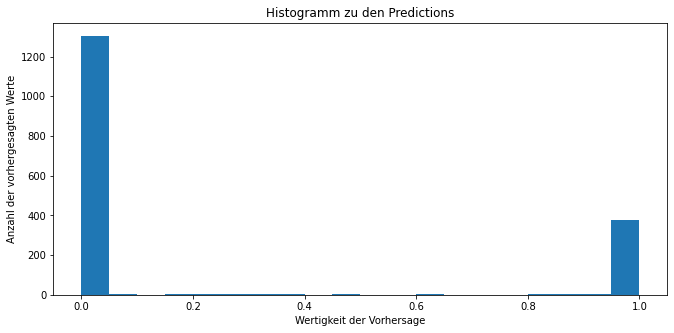

In [54]:
plt.figure(figsize=(11,5))
plt.hist(y_pred, bins=20)
plt.title("Histogramm zu den Predictions")

plt.xlabel("Wertigkeit der Vorhersage")
plt.ylabel("Anzahl der vorhergesagten Werte")

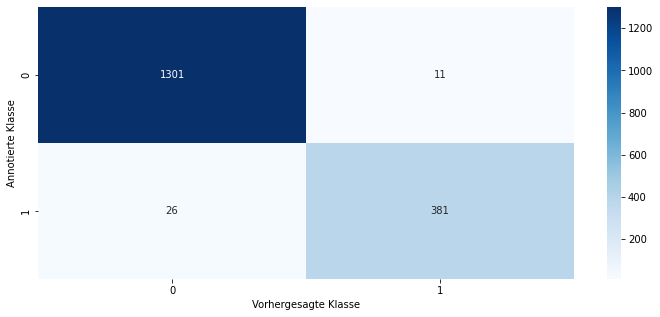

In [48]:
import seaborn as sns

plt.figure(figsize=(12,5))
sns.heatmap(confusion, annot=True, fmt="d", cmap=plt.cm.Blues)

plt.xlabel("Vorhergesagte Klasse")
plt.ylabel("Annotierte Klasse")
plt.show()